# **Activity 2: Classification and Clustering**

**This notebook is prepared as the second activity for the course BIGDATA-Big Data and Data Mining at EETAC, UPC. Link to the notebook- [Kaggle](https://www.kaggle.com/code/hasanccr92/bigdata-a2)**

**Importing necessary libraries**

In [ ]:
# Standard Libraries
import os
import time

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Deep Learning
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, cohen_kappa_score
)
from sklearn.cluster import KMeans as SklearnKMeans, AgglomerativeClustering, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from skimage.transform import resize
from sklearn.utils import resample

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# PySpark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors

# Optimization
from scipy.optimize import linear_sum_assignment
from scipy.optimize import linear_sum_assignment as linear_assignment

# **WEEK 1**

# Downloading the two datasets

In [ ]:
digits = load_digits()
x_digits, y_digits = digits['data'], digits['target']

In [ ]:
#MNIST dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Flattening MNIST

In [ ]:
# Flatten MNIST
x_train_mnist_flattened = x_train_mnist.reshape(x_train_mnist.shape[0], -1)
x_test_mnist_flattened = x_test_mnist.reshape(x_test_mnist.shape[0], -1)

#shapes
print("x_train_mnist_flattened shape:", x_train_mnist_flattened.shape)
print("y_train_mnist shape:", y_train_mnist.shape)

x_train_mnist_flattened shape: (60000, 784)
y_train_mnist shape: (60000,)


# Splitting the training datasets in 85% for training and 15% for validation. MNIST is already split. So splitting only digits dataset

In [ ]:
#85/15 split of digit
x_train_digits, x_test_digits, y_train_digits, y_test_digits = train_test_split(
    x_digits, y_digits, test_size=0.15, random_state=42
)

print("Digits - Training data shape:", x_train_digits.shape)
print("Digits - Test data shape:", x_test_digits.shape)


Digits - Training data shape: (1527, 64)
Digits - Test data shape: (270, 64)


# Training

**Training Random Forest on MNIST and digits dataset (scikit-learn)**

In [ ]:
#RF on MNIST training
start_train = time.time()
rf_mnist = RandomForestClassifier(random_state=42)
rf_mnist.fit(x_train_mnist_flattened, y_train_mnist)
end_train = time.time()
train_time_mnist = end_train - start_train

#RF on Digits training
start_train = time.time()
rf_digits = RandomForestClassifier(random_state=42)
rf_digits.fit(x_train_digits, y_train_digits)
end_train = time.time()
train_time_digits = end_train - start_train

**Training Logistic Regression on MNIST and digits dataset (pyspark)**

In [ ]:
#Initialize Spark session
spark = SparkSession.builder \
    .appName("MNIST_Digits") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "64") \
    .getOrCreate()

#MNIST training data to Spark DataFrame
train_data_mnist = spark.createDataFrame([
    (int(y), Vectors.dense(x)) for x, y in zip(x_train_mnist_flattened, y_train_mnist)
], ["label", "features"])

# Convert MNIST test data to Spark DataFrame
test_data_mnist = spark.createDataFrame([
    (int(y), Vectors.dense(x)) for x, y in zip(x_test_mnist_flattened, y_test_mnist)
], ["label", "features"])


#digits training data to Spark DataFrame
train_data_digits = spark.createDataFrame([
    (int(y), Vectors.dense(x)) for x, y in zip(x_train_digits, y_train_digits)
], ["label", "features"])

#digits test data to Spark DataFrame
test_data_digits = spark.createDataFrame([
    (int(y), Vectors.dense(x)) for x, y in zip(x_test_digits, y_test_digits)
], ["label", "features"])

# Train Logistic Regression on MNIST
start_train = time.time()
lr_mnist = LogisticRegression(maxIter=10, regParam=0.01)
lr_model_mnist = lr_mnist.fit(train_data_mnist)
end_train = time.time()
train_time_mnist_spark = end_train - start_train

# Train Logistic Regression on digits
start_train = time.time()
lr_digits = LogisticRegression(maxIter=10, regParam=0.01)
lr_model_digits = lr_digits.fit(train_data_digits)
end_train = time.time()
train_time_digits_spark = end_train - start_train

# Executing models for test data and showing output

**For random forest (scikit-learn)**

In [ ]:
# Scikit-learn Random Forest Evaluation for both datasets

print("----- Scikit-learn Random Forest Evaluation -----\n")

#Evaluate RF for MNIST
print("Evaluating Scikit-learn Random Forest for MNIST...")
start_pred = time.time()
y_pred_mnist_rf = rf_mnist.predict(x_test_mnist_flattened)
end_pred = time.time()
pred_time_mnist_rf = end_pred - start_pred
print(f"Training time: {train_time_mnist:.4f} seconds")
print(f"Prediction time: {pred_time_mnist_rf:.4f} seconds")

#metrics for RF MNIST
accuracy_mnist_rf = accuracy_score(y_test_mnist, y_pred_mnist_rf)
precision_mnist_rf = precision_score(y_test_mnist, y_pred_mnist_rf, average='weighted')
recall_mnist_rf = recall_score(y_test_mnist, y_pred_mnist_rf, average='weighted')
f1_mnist_rf = f1_score(y_test_mnist, y_pred_mnist_rf, average='weighted')
kappa_mnist_rf = cohen_kappa_score(y_test_mnist, y_pred_mnist_rf)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_mnist_rf:.4f}")
print(f"Precision: {precision_mnist_rf:.4f}")
print(f"Recall: {recall_mnist_rf:.4f}")
print(f"F1 Score: {f1_mnist_rf:.4f}")
print(f"Cohen's Kappa: {kappa_mnist_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_mnist, y_pred_mnist_rf))

# Confusion Matrix for Scikit-learn RF MNIST
cm_mnist_rf = confusion_matrix(y_test_mnist, y_pred_mnist_rf)
print("\nConfusion Matrix")
print(cm_mnist_rf)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_mnist_rf, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - MNIST Random Forest (Scikit-learn)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

#Evaluate RF for Digits
print("\nEvaluating Scikit-learn Random Forest for Digits...")
start_pred = time.time()
y_pred_digits_rf = rf_digits.predict(x_test_digits)
end_pred = time.time()
pred_time_digits_rf = end_pred - start_pred
print(f"Training time: {train_time_digits:.4f} seconds")
print(f"Prediction time: {pred_time_digits_rf:.4f} seconds")

#metrics for RF Digits
accuracy_digits_rf = accuracy_score(y_test_digits, y_pred_digits_rf)
precision_digits_rf = precision_score(y_test_digits, y_pred_digits_rf, average='weighted')
recall_digits_rf = recall_score(y_test_digits, y_pred_digits_rf, average='weighted')
f1_digits_rf = f1_score(y_test_digits, y_pred_digits_rf, average='weighted')
kappa_digits_rf = cohen_kappa_score(y_test_digits, y_pred_digits_rf)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_digits_rf:.4f}")
print(f"Precision: {precision_digits_rf:.4f}")
print(f"Recall: {recall_digits_rf:.4f}")
print(f"F1 Score: {f1_digits_rf:.4f}")
print(f"Cohen's Kappa: {kappa_digits_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_digits, y_pred_digits_rf))

# Confusion Matrix for Scikit-learn RF Digits
cm_digits_rf = confusion_matrix(y_test_digits, y_pred_digits_rf)
print("\nConfusion Matrix")
print(cm_digits_rf)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_digits_rf, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - Digits Random Forest (Scikit-learn)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# Save metrics for later comparison
rf_metrics = {
    'mnist': {
        'accuracy': accuracy_mnist_rf,
        'precision': precision_mnist_rf,
        'recall': recall_mnist_rf,
        'f1': f1_mnist_rf,
        'kappa': kappa_mnist_rf,
        'pred_time': pred_time_mnist_rf,
        'train_time': train_time_mnist
    },
    'digits': {
        'accuracy': accuracy_digits_rf,
        'precision': precision_digits_rf,
        'recall': recall_digits_rf,
        'f1': f1_digits_rf,
        'kappa': kappa_digits_rf,
        'pred_time': pred_time_digits_rf,
        'train_time': train_time_digits
    }
}

----- Scikit-learn Random Forest Evaluation -----

Evaluating Scikit-learn Random Forest for MNIST...
Training time: 45.8784 seconds
Prediction time: 0.4897 seconds

Basic Classification Metrics:
Accuracy: 0.9705
Precision: 0.9705
Recall: 0.9705
F1 Score: 0.9705
Cohen's Kappa: 0.9672

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.

**For logistic regression (pyspark)**

In [ ]:
print("----- PySpark Logistic Regression Evaluation -----\n")

#PySpark LR for MNIST
print("Evaluating PySpark Logistic Regression for MNIST...")
start_pred = time.time()
predictions_mnist = lr_model_mnist.transform(test_data_mnist)
end_pred = time.time()
pred_time_mnist_spark = end_pred - start_pred
print(f"Training time: {train_time_mnist_spark:.4f} seconds")
print(f"Prediction time: {pred_time_mnist_spark:.4f} seconds")

#metrics for PySpark LR MNIST
pred_df_mnist = predictions_mnist.select("label", "prediction").toPandas()
y_true_mnist = pred_df_mnist["label"].values
y_pred_mnist = pred_df_mnist["prediction"].values

# PySpark evaluator for basic metrics
evaluator = MulticlassClassificationEvaluator()
accuracy_mnist_spark = evaluator.evaluate(predictions_mnist, {evaluator.metricName: "accuracy"})
precision_mnist_spark = evaluator.evaluate(predictions_mnist, {evaluator.metricName: "weightedPrecision"})
recall_mnist_spark = evaluator.evaluate(predictions_mnist, {evaluator.metricName: "weightedRecall"})
f1_mnist_spark = evaluator.evaluate(predictions_mnist, {evaluator.metricName: "f1"})
kappa_mnist_spark = cohen_kappa_score(y_true_mnist, y_pred_mnist)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_mnist_spark:.4f}")
print(f"Precision: {precision_mnist_spark:.4f}")
print(f"Recall: {recall_mnist_spark:.4f}")
print(f"F1 Score: {f1_mnist_spark:.4f}")
print(f"Cohen's Kappa: {kappa_mnist_spark:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_mnist, y_pred_mnist))

cm_mnist_spark = confusion_matrix(y_true_mnist, y_pred_mnist)
print("\nConfusion Matrix")
print(cm_mnist_spark)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_mnist_spark, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - MNIST Logistic Regression (PySpark)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

#Evaluate PySpark LR for Digits
print("\nEvaluating PySpark Logistic Regression for Digits...")
start_pred = time.time()
predictions_digits = lr_model_digits.transform(test_data_digits)
end_pred = time.time()
pred_time_digits_spark = end_pred - start_pred
print(f"Training time: {train_time_digits_spark:.4f} seconds")
print(f"Prediction time: {pred_time_digits_spark:.4f} seconds")

#metrics for PySpark LR Digits
pred_df_digits = predictions_digits.select("label", "prediction").toPandas()
y_true_digits = pred_df_digits["label"].values
y_pred_digits = pred_df_digits["prediction"].values

accuracy_digits_spark = evaluator.evaluate(predictions_digits, {evaluator.metricName: "accuracy"})
precision_digits_spark = evaluator.evaluate(predictions_digits, {evaluator.metricName: "weightedPrecision"})
recall_digits_spark = evaluator.evaluate(predictions_digits, {evaluator.metricName: "weightedRecall"})
f1_digits_spark = evaluator.evaluate(predictions_digits, {evaluator.metricName: "f1"})
kappa_digits_spark = cohen_kappa_score(y_true_digits, y_pred_digits)

# Print metrics for PySpark LR Digits
print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_digits_spark:.4f}")
print(f"Precision: {precision_digits_spark:.4f}")
print(f"Recall: {recall_digits_spark:.4f}")
print(f"F1 Score: {f1_digits_spark:.4f}")
print(f"Cohen's Kappa: {kappa_digits_spark:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_digits, y_pred_digits))

# Confusion Matrix for PySpark LR Digits
cm_digits_spark = confusion_matrix(y_true_digits, y_pred_digits)
print("\nConfusion Matrix")
print(cm_digits_spark)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_digits_spark, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - Digits Logistic Regression (PySpark)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# Save metrics for later comparison
spark_metrics = {
    'mnist': {
        'accuracy': accuracy_mnist_spark,
        'precision': precision_mnist_spark,
        'recall': recall_mnist_spark,
        'f1': f1_mnist_spark,
        'kappa': kappa_mnist_spark,
        'pred_time': pred_time_mnist_spark,
        'train_time': train_time_mnist_spark
    },
    'digits': {
        'accuracy': accuracy_digits_spark,
        'precision': precision_digits_spark,
        'recall': recall_digits_spark,
        'f1': f1_digits_spark,
        'kappa': kappa_digits_spark,
        'pred_time': pred_time_digits_spark,
        'train_time': train_time_digits_spark
    }
}

spark.stop()

----- PySpark Logistic Regression Evaluation -----

Evaluating PySpark Logistic Regression for MNIST...
Training time: 42.4732 seconds
Prediction time: 0.0812 seconds

Basic Classification Metrics:
Accuracy: 0.9181
Precision: 0.9179
Recall: 0.9181
F1 Score: 0.9177
Cohen's Kappa: 0.9090

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.94      0.97      0.96      1135
           2       0.94      0.89      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.85      0.88       892
           6       0.92      0.96      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.89      0.86      0.87       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      

# Evaluation and Comparison of all the models with classification metrics

In [ ]:
# Overall Comparison df
print("----- Overall Model Comparison -----\n")

#metrics data
data = [
    {
        "Dataset": "MNIST",
        "Model": "PySpark LR",
        "Accuracy": spark_metrics['mnist']['accuracy'],
        "Precision": spark_metrics['mnist']['precision'],
        "Recall": spark_metrics['mnist']['recall'],
        "F1": spark_metrics['mnist']['f1'],
        "Kappa": spark_metrics['mnist']['kappa'],
        "Train Time": spark_metrics['mnist']['train_time'],
        "Pred Time": spark_metrics['mnist']['pred_time']
    },
    {
        "Dataset": "MNIST",
        "Model": "Scikit-learn RF",
        "Accuracy": rf_metrics['mnist']['accuracy'],
        "Precision": rf_metrics['mnist']['precision'],
        "Recall": rf_metrics['mnist']['recall'],
        "F1": rf_metrics['mnist']['f1'],
        "Kappa": rf_metrics['mnist']['kappa'],
        "Train Time": rf_metrics['mnist']['train_time'],
        "Pred Time": rf_metrics['mnist']['pred_time']
    },
    {
        "Dataset": "Digits",
        "Model": "PySpark LR",
        "Accuracy": spark_metrics['digits']['accuracy'],
        "Precision": spark_metrics['digits']['precision'],
        "Recall": spark_metrics['digits']['recall'],
        "F1": spark_metrics['digits']['f1'],
        "Kappa": spark_metrics['digits']['kappa'],
        "Train Time": spark_metrics['digits']['train_time'],
        "Pred Time": spark_metrics['digits']['pred_time']
    },
    {
        "Dataset": "Digits",
        "Model": "Scikit-learn RF",
        "Accuracy": rf_metrics['digits']['accuracy'],
        "Precision": rf_metrics['digits']['precision'],
        "Recall": rf_metrics['digits']['recall'],
        "F1": rf_metrics['digits']['f1'],
        "Kappa": rf_metrics['digits']['kappa'],
        "Train Time": rf_metrics['digits']['train_time'],
        "Pred Time": rf_metrics['digits']['pred_time']
    }
]

df = pd.DataFrame(data)
print(df)


print("\nSummary:")
best_accuracy_model = max([
    ("MNIST LR", spark_metrics['mnist']['accuracy']),
    ("MNIST RF", rf_metrics['mnist']['accuracy']),
    ("Digits LR", spark_metrics['digits']['accuracy']),
    ("Digits RF", rf_metrics['digits']['accuracy'])
], key=lambda x: x[1])

fastest_model = min([
    ("MNIST LR", spark_metrics['mnist']['pred_time']),
    ("MNIST RF", rf_metrics['mnist']['pred_time']),
    ("Digits LR", spark_metrics['digits']['pred_time']),
    ("Digits RF", rf_metrics['digits']['pred_time'])
], key=lambda x: x[1])

print(f"- Best accuracy achieved by {best_accuracy_model[0]} with {best_accuracy_model[1]:.4f}")
print(f"- Fastest prediction time achieved by {fastest_model[0]} with {fastest_model[1]:.4f} seconds")

# MNIST dataset comparison
print("\nOn MNIST dataset:")
if spark_metrics['mnist']['accuracy'] > rf_metrics['mnist']['accuracy']:
    diff = spark_metrics['mnist']['accuracy'] - rf_metrics['mnist']['accuracy']
    print(f"- Logistic Regression outperforms Random Forest by {diff:.4f} in accuracy")
else:
    diff = rf_metrics['mnist']['accuracy'] - spark_metrics['mnist']['accuracy']
    print(f"- Random Forest outperforms Logistic Regression by {diff:.4f} in accuracy")

# Digits dataset comparison
print("\nOn Digits dataset:")
if spark_metrics['digits']['accuracy'] > rf_metrics['digits']['accuracy']:
    diff = spark_metrics['digits']['accuracy'] - rf_metrics['digits']['accuracy']
    print(f"- Logistic Regression outperforms Random Forest by {diff:.4f} in accuracy")
else:
    diff = rf_metrics['digits']['accuracy'] - spark_metrics['digits']['accuracy']
    print(f"- Random Forest outperforms Logistic Regression by {diff:.4f} in accuracy")

----- Overall Model Comparison -----

  Dataset            Model  Accuracy  Precision    Recall        F1     Kappa  \
0   MNIST       PySpark LR  0.918100   0.917884  0.918100  0.917728  0.908958   
1   MNIST  Scikit-learn RF  0.970500   0.970496  0.970500  0.970472  0.967209   
2  Digits       PySpark LR  0.955556   0.957099  0.955556  0.955670  0.950333   
3  Digits  Scikit-learn RF  0.970370   0.971549  0.970370  0.970234  0.966891   

   Train Time  Pred Time  
0   42.473245   0.081233  
1   45.878416   0.489730  
2    1.952087   0.107942  
3    0.401121   0.011242  

Summary:
- Best accuracy achieved by MNIST RF with 0.9705
- Fastest prediction time achieved by Digits RF with 0.0112 seconds

On MNIST dataset:
- Random Forest outperforms Logistic Regression by 0.0524 in accuracy

On Digits dataset:
- Random Forest outperforms Logistic Regression by 0.0148 in accuracy


# Optional- Fine tuning hyper parameters (only for scikit-learn model, on both datasets)

In [ ]:
param_grid_rf = {
    'n_estimators': [200,300],
    'max_depth': [None,10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [ ]:
rf = RandomForestClassifier(random_state=42)

#GridSearchCV with 10-fold cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)


# Fit GridSearchCV on MNIST training data
grid_search_rf.fit(x_train_mnist_flattened, y_train_mnist)
print("-------------For MNIST Dataset--------------")
# Best parameters and cross-validation score
print("Random Forest - Best Parameters:", grid_search_rf.best_params_)
print("Random Forest - Best Cross-Validation Accuracy:", grid_search_rf.best_score_)

# Evaluate on MNIST test data
y_test_pred_rf = grid_search_rf.predict(x_test_mnist_flattened)
print("Random Forest - Test Accuracy:", accuracy_score(y_test_mnist, y_test_pred_rf))
print("Random Forest - Classification Report:")
print(classification_report(y_test_mnist, y_test_pred_rf))

#Now on the digits dataset
grid_search_rf_digits = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on digits training data
grid_search_rf_digits.fit(x_train_digits, y_train_digits)
print("-------------For Digits Dataset--------------")
# Best parameters and cross-validation score for digits dataset
print("Random Forest (Digits) - Best Parameters:", grid_search_rf_digits.best_params_)
print("Random Forest (Digits) - Best Cross-Validation Accuracy:", grid_search_rf_digits.best_score_)

# Evaluate on digits test data
y_test_pred_rf_digits = grid_search_rf_digits.predict(x_test_digits)
print("Random Forest (Digits) - Test Accuracy:", accuracy_score(y_test_digits, y_test_pred_rf_digits))
print("Random Forest (Digits) - Classification Report:")
print(classification_report(y_test_digits, y_test_pred_rf_digits))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


-------------For MNIST Dataset--------------
Random Forest - Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}
Random Forest - Best Cross-Validation Accuracy: 0.9736499999999999
Random Forest - Test Accuracy: 0.9734
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97

# **WEEK 2**

# CNN Model

In [ ]:
def create_cnn_model(input_shape):
    model = keras.Sequential([
        #reshape
        layers.Reshape(input_shape + (1,), input_shape=(np.prod(input_shape),)),

        #conv 1
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        #conv 2
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Flatten for dense layers
        layers.Flatten(),

        #dense 1
        layers.Dense(128, activation='relu'),

        #output dense 2
        layers.Dense(10, activation='softmax')
    ])

    #compile
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Digits 8x8 pixels images.

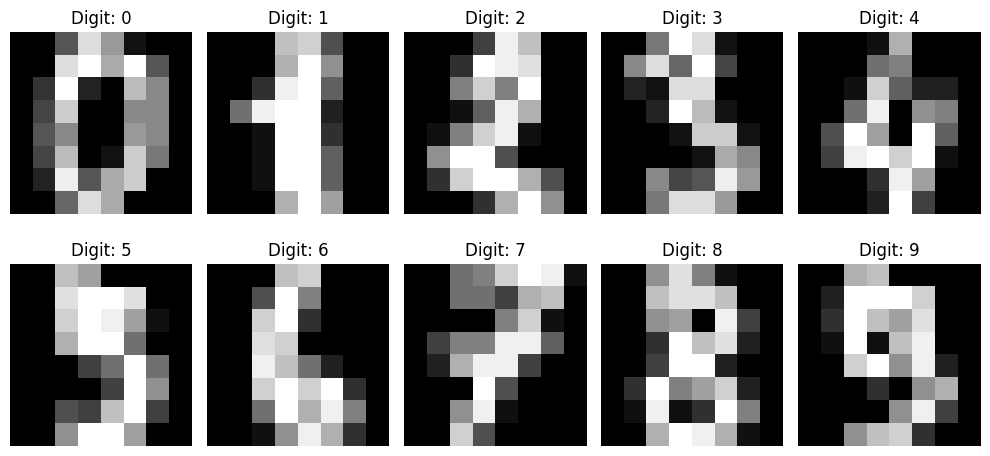

In [ ]:
# Reshape from (n_samples, 64) to (n_samples, 8, 8)
x_digits_reshaped = x_digits.reshape(-1, 8, 8)

# For visualization
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_digits_reshaped[y_digits == i][0], cmap='gray')
    plt.title(f'Digit: {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

**Normalizing for faster convergence**

In [ ]:
x_train_digits = x_train_digits / 16.0
x_test_digits = x_test_digits / 16.0
x_train_mnist_flattened = x_train_mnist_flattened / 255.0
x_test_mnist_flattened = x_test_mnist_flattened / 255.0

# Training with CNN

In [ ]:
#digits
digits_model = create_cnn_model((8, 8))
print("Digits Model Summary:")
digits_model.summary()

# Train digits model with timing
start_train_time_digits = time.time()
digits_history = digits_model.fit(
    x_train_digits, y_train_digits,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
end_train_time_digits = time.time()
train_time_digits_cnn = end_train_time_digits - start_train_time_digits


#MNIST (28x28)
mnist_model = create_cnn_model((28, 28))
print("MNIST Model Summary:")
mnist_model.summary()

#Train MNIST
start_train_time_mnist = time.time()
mnist_history = mnist_model.fit(
    x_train_mnist_flattened, y_train_mnist,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)
end_train_time_mnist = time.time()
train_time_mnist_cnn = end_train_time_mnist - start_train_time_mnist

Digits Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 8, 8, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,002 (207.04 KB)

 Trainable params: 53,002 (207.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2707 - loss: 2.2190 - val_accuracy: 0.7320 - val_loss: 1.6126
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7906 - loss: 1.1749 - val_accuracy: 0.9085 - val_loss: 0.4358
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9190 - loss: 0.3414 - val_accuracy: 0.9281 - val_loss: 0.2099
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9635 - loss: 0.1787 - val_accuracy: 0.9477 - val_loss: 0.1660
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9695 - loss: 0.1290 - val_accuracy: 0.9673 - val_loss: 0.1101
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9741 - loss: 0.1052 - val_accuracy: 0.9804 - val_loss: 0.0774
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9801 - loss: 0.0882 - val_accuracy: 0.9739 - val_loss: 0.0860
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9840 - loss: 0.0733 - val_accuracy: 0.9804 - val_loss

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.8706 - loss: 0.4615 - val_accuracy: 0.9848 - val_loss: 0.0531
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.9827 - loss: 0.0563 - val_accuracy: 0.9883 - val_loss: 0.0410
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.9885 - loss: 0.0365 - val_accuracy: 0.9873 - val_loss: 0.0389
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9914 - loss: 0.0285 - val_accuracy: 0.9903 - val_loss: 0.0363
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.9937 - loss: 0.0194 - val_accuracy: 0.9888 - val_loss: 0.0376
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.9948 - loss: 0.0158 - val_accuracy: 0.9898 - val_loss: 0.0360
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.9960 - loss: 0.0127 - val_accuracy: 0.9907 - val_loss: 0.0350
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.9971 - loss: 0.0095 - 

# Plotting accuracy and loss for train-val

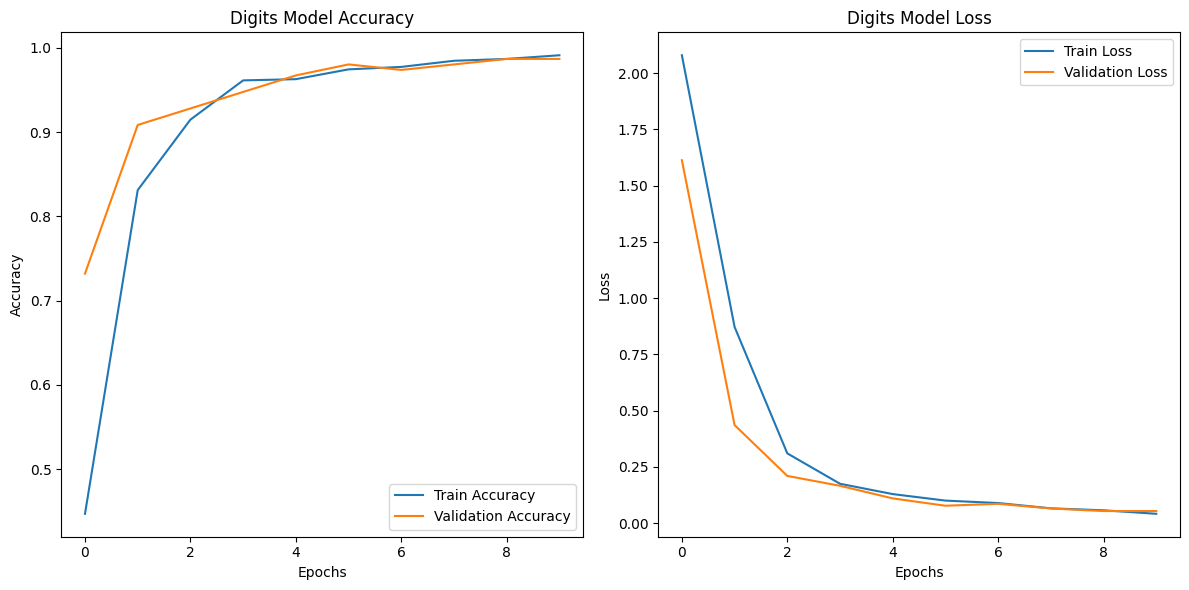

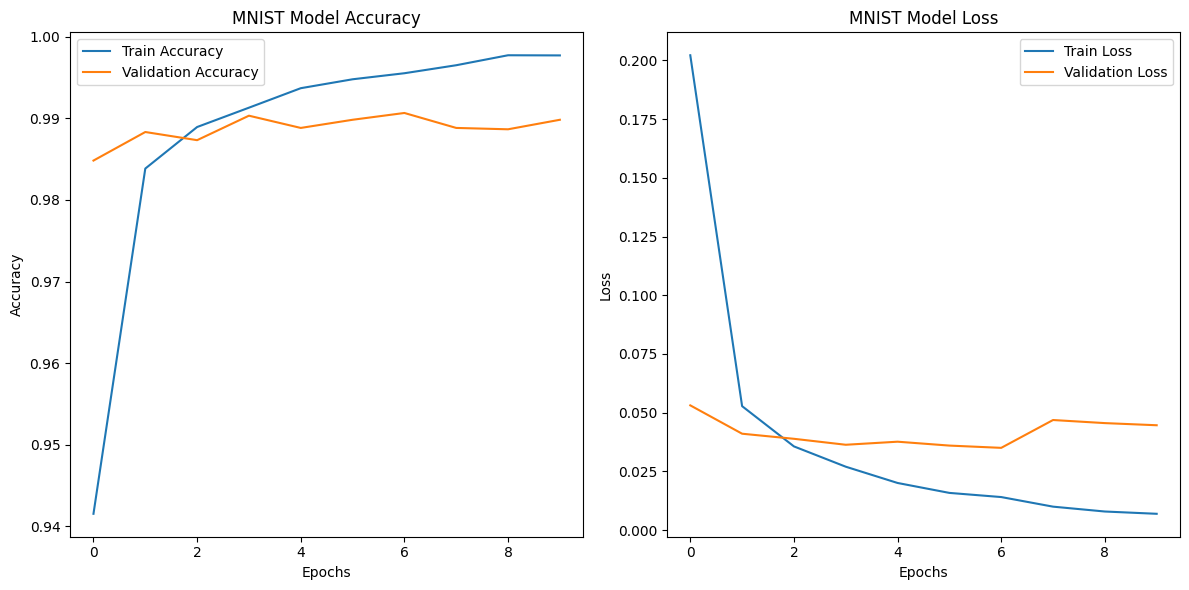

In [ ]:
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training and validation curves for both models
plot_history(digits_history, 'Digits Model')
plot_history(mnist_history, 'MNIST Model')

# Evaluating CNN on test set of both datasets

In [ ]:
print("\nEvaluating CNN for Digits...")
start_pred = time.time()
y_pred_digits_cnn_probs = digits_model.predict(x_test_digits)
y_pred_digits_cnn = y_pred_digits_cnn_probs.argmax(axis=1)
end_pred = time.time()
pred_time_digits_cnn = end_pred - start_pred
print(f"Training time: {train_time_digits_cnn:.4f} seconds")
print(f"Prediction time: {pred_time_digits_cnn:.4f} seconds")

# Metrics for CNN Digits
accuracy_digits_cnn = accuracy_score(y_test_digits, y_pred_digits_cnn)
precision_digits_cnn = precision_score(y_test_digits, y_pred_digits_cnn, average='weighted')
recall_digits_cnn = recall_score(y_test_digits, y_pred_digits_cnn, average='weighted')
f1_digits_cnn = f1_score(y_test_digits, y_pred_digits_cnn, average='weighted')
kappa_digits_cnn = cohen_kappa_score(y_test_digits, y_pred_digits_cnn)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_digits_cnn:.4f}")
print(f"Precision: {precision_digits_cnn:.4f}")
print(f"Recall: {recall_digits_cnn:.4f}")
print(f"F1 Score: {f1_digits_cnn:.4f}")
print(f"Cohen's Kappa: {kappa_digits_cnn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_digits, y_pred_digits_cnn))

# Confusion Matrix for CNN Digits
cm_digits_cnn = confusion_matrix(y_test_digits, y_pred_digits_cnn)
print("\nConfusion Matrix")
print(cm_digits_cnn)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_digits_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - Digits CNN')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

print("\nEvaluating CNN for MNIST...")
start_pred = time.time()
y_pred_mnist_cnn_probs = mnist_model.predict(x_test_mnist_flattened)
y_pred_mnist_cnn = y_pred_mnist_cnn_probs.argmax(axis=1)
end_pred = time.time()
pred_time_mnist_cnn = end_pred - start_pred
print(f"Training time: {train_time_mnist_cnn:.4f} seconds")
print(f"Prediction time: {pred_time_mnist_cnn:.4f} seconds")

# Metrics for CNN MNIST
accuracy_mnist_cnn = accuracy_score(y_test_mnist, y_pred_mnist_cnn)
precision_mnist_cnn = precision_score(y_test_mnist, y_pred_mnist_cnn, average='weighted')
recall_mnist_cnn = recall_score(y_test_mnist, y_pred_mnist_cnn, average='weighted')
f1_mnist_cnn = f1_score(y_test_mnist, y_pred_mnist_cnn, average='weighted')
kappa_mnist_cnn = cohen_kappa_score(y_test_mnist, y_pred_mnist_cnn)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_mnist_cnn:.4f}")
print(f"Precision: {precision_mnist_cnn:.4f}")
print(f"Recall: {recall_mnist_cnn:.4f}")
print(f"F1 Score: {f1_mnist_cnn:.4f}")
print(f"Cohen's Kappa: {kappa_mnist_cnn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_mnist, y_pred_mnist_cnn))

# Confusion Matrix for CNN MNIST
cm_mnist_cnn = confusion_matrix(y_test_mnist, y_pred_mnist_cnn)
print("\nConfusion Matrix")
print(cm_mnist_cnn)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_mnist_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - MNIST CNN')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# Save metrics for later comparison
cnn_metrics = {
    'mnist': {
        'accuracy': accuracy_mnist_cnn,
        'precision': precision_mnist_cnn,
        'recall': recall_mnist_cnn,
        'f1': f1_mnist_cnn,
        'kappa': kappa_mnist_cnn,
        'pred_time': pred_time_mnist_cnn,
        'train_time': train_time_mnist_cnn
    },
    'digits': {
        'accuracy': accuracy_digits_cnn,
        'precision': precision_digits_cnn,
        'recall': recall_digits_cnn,
        'f1': f1_digits_cnn,
        'kappa': kappa_digits_cnn,
        'pred_time': pred_time_digits_cnn,
        'train_time': train_time_digits_cnn
    }
}


Evaluating CNN for Digits...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training time: 4.7984 seconds
Prediction time: 0.2428 seconds

Basic Classification Metrics:
Accuracy: 0.9852
Precision: 0.9858
Recall: 0.9852
F1 Score: 0.9852
Cohen's Kappa: 0.9834

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.95      1.00      0.97        18
           2       1.00      1.00      1.00        26
           3       1.00      0.96      0.98        24
           4       1.00      1.00      1.00        37
           5       0.94      1.00      0.97        33
           6       1.00      0.97      0.98        30
           7       1.00      1.00      1.00        26
           8       0.95      0.95      0.95        19
           9       1.00      0.97      0.99        34

    accuracy                           0.99       270
   macro avg       0.98      0.98      0.98       270
weighted avg       0.9

# Optional: Using a pretrained model from kaggle

Doing it only for MNIST dataset, as digits dataset pretrained model is not readily available.

**Model link: [MNIST 99% Pre-trained Model](https://www.kaggle.com/models/adhul000/mnist-99/TensorFlow2/default/1)**

In [ ]:
model_path = '/kaggle/input/mnist-99/tensorflow2/default/1/best_model.h5'
pr_model = load_model(model_path)
pr_model.summary()  #to see the arch

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 48)          │          27,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 192)                 │         230,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 265,436 (1.01 MB)

 Trainable params: 265,434 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

**Predicting on test data**

In [ ]:
x_test_mnist_pr = x_test_mnist_flattened.reshape(-1, 28, 28, 1)  # Reshape

start_time = time.time()
pr_predictions = pr_model.predict(x_test_mnist_pr)
end_time = time.time()

pred_time_mnist_pr = end_time - start_time

pr_predicted_labels = np.argmax(pr_predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


**Evaluation and comparison with CNN**

In [ ]:
accuracy_mnist_pr = accuracy_score(y_test_mnist, pr_predicted_labels)
precision_mnist_pr = precision_score(y_test_mnist, pr_predicted_labels, average='weighted')
recall_mnist_pr = recall_score(y_test_mnist, pr_predicted_labels, average='weighted')
f1_mnist_pr = f1_score(y_test_mnist, pr_predicted_labels, average='weighted')
kappa_mnist_pr = cohen_kappa_score(y_test_mnist, pr_predicted_labels)

pr_metrics = {
    'accuracy': accuracy_mnist_pr,
    'precision': precision_mnist_pr,
    'recall': recall_mnist_pr,
    'f1': f1_mnist_pr,
    'kappa': kappa_mnist_pr,
    'pred_time': pred_time_mnist_pr,  # Prediction time
    'train_time': 'NA'
}

In [ ]:
data = {
    'Model': ['Pretained CNN', 'CNN'],
    'Accuracy': [accuracy_mnist_pr, accuracy_mnist_cnn],
    'Precision': [precision_mnist_pr, precision_mnist_cnn],
    'Recall': [recall_mnist_pr, recall_mnist_cnn],
    'F1 Score': [f1_mnist_pr, f1_mnist_cnn],
    'Cohen Kappa': [kappa_mnist_pr, kappa_mnist_cnn],
    'Prediction Time': [pred_time_mnist_pr, pred_time_mnist_cnn],
    'Training Time': ['NA', train_time_mnist_cnn]   # pretrained has no training time
}

df_comparison = pd.DataFrame(data)
print(df_comparison)

           Model  Accuracy  Precision  Recall  F1 Score  Cohen Kappa  \
0  Pretained CNN    0.9959   0.995905  0.9959  0.995899     0.995443   
1            CNN    0.9904   0.990456  0.9904  0.990407     0.989329   

   Prediction Time Training Time  
0         2.448840            NA  
1         2.520138    326.665714  


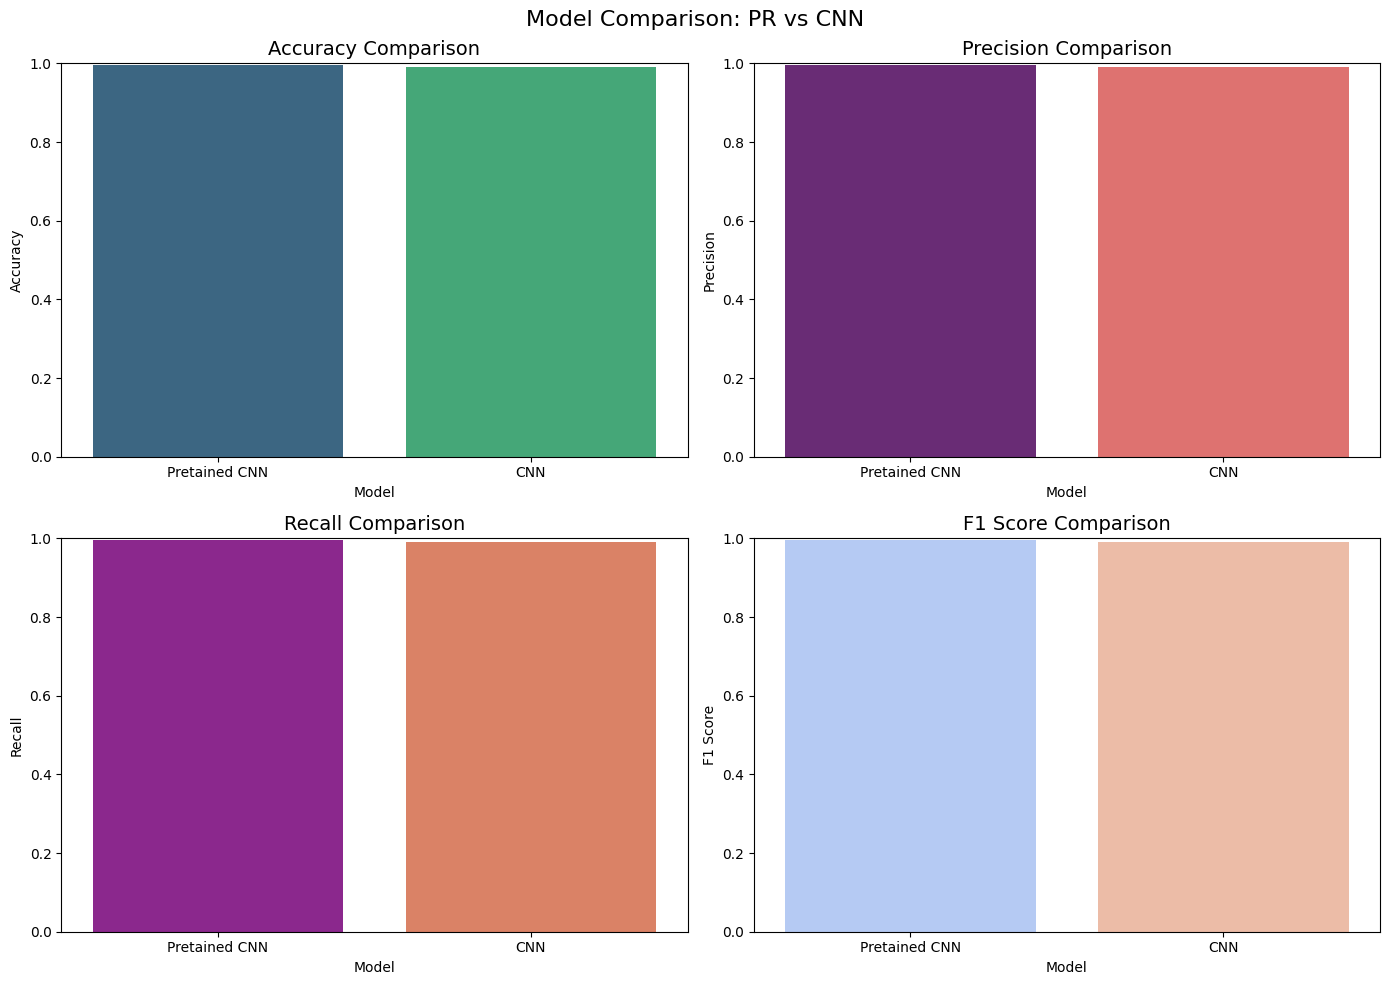

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Comparison: PR vs CNN', fontsize=16)

# Plot Accuracy
sns.barplot(ax=axes[0, 0], x='Model', y='Accuracy', data=df_comparison, palette='viridis')
axes[0, 0].set_title('Accuracy Comparison', fontsize=14)
axes[0, 0].set_ylim(0, 1)  # Set y-axis limit for better visualization

# Plot Precision
sns.barplot(ax=axes[0, 1], x='Model', y='Precision', data=df_comparison, palette='magma')
axes[0, 1].set_title('Precision Comparison', fontsize=14)
axes[0, 1].set_ylim(0, 1)

# Plot Recall
sns.barplot(ax=axes[1, 0], x='Model', y='Recall', data=df_comparison, palette='plasma')
axes[1, 0].set_title('Recall Comparison', fontsize=14)
axes[1, 0].set_ylim(0, 1)

# Plot F1 Score
sns.barplot(ax=axes[1, 1], x='Model', y='F1 Score', data=df_comparison, palette='coolwarm')
axes[1, 1].set_title('F1 Score Comparison', fontsize=14)
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# **WEEK 3**

Scikit-learn Clustering Algorithms:

    K-Means: A popular clustering algorithm that partitions the data into K clusters by minimizing the variance within each cluster.

    DBSCAN: Density-Based Spatial Clustering of Applications with Noise. It groups together points that are closely packed together, marking points that are far away as outliers.

    Agglomerative Clustering: A hierarchical clustering method that builds nested clusters by merging or splitting them successively.

Spark ML Clustering Algorithms:

    K-Means: Similar to scikit-learn's K-Means, but optimized for distributed computing.

    Gaussian Mixture Model (GMM): A probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions.

For this assignment, we will use K-Means from both scikit-learn and Spark ML

**Prepare data for clustering**

In [ ]:
# Normalize the data (already done in previous steps)
x_train_digits_normalized = x_train_digits
x_test_digits_normalized = x_test_digits
x_train_mnist_normalized = x_train_mnist_flattened
x_test_mnist_normalized = x_test_mnist_flattened

**A function for matching the labels**

In [ ]:
def match_labels(true_labels, cluster_labels, num_classes=10):
    num_classes = len(np.unique(true_labels))
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    for true_label, cluster_label in zip(true_labels, cluster_labels):
        confusion_matrix[true_label, cluster_label] += 1

    #Hungarian algorithm to find the best mapping
    row_indices, col_indices = linear_assignment(-confusion_matrix)

    #a mapping from cluster labels to true labels
    label_mapping = np.zeros(num_classes, dtype=np.int64)
    for cluster_label, true_label in zip(col_indices, row_indices):
        label_mapping[cluster_label] = true_label

    #Map cluster labels to the true labels
    mapped_labels = np.array([label_mapping[label] for label in cluster_labels])
    return mapped_labels

# Sklearn k means training

In [ ]:
# Scikit-learn K-Means for Digits
start_time = time.time()
sklearn_kmeans_digits = SklearnKMeans(n_clusters=10, random_state=42)
sklearn_kmeans_digits.fit(x_train_digits_normalized)
train_sklearn_digits_time = time.time() - start_time

# Scikit-learn K-Means for MNIST
start_time = time.time()
sklearn_kmeans_mnist = SklearnKMeans(n_clusters=10, random_state=42)
sklearn_kmeans_mnist.fit(x_train_mnist_normalized)
train_sklearn_mnist_time = time.time() - start_time

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Evaluate sk learn kmeans for both test data

In [ ]:
print("----- Scikit-learn K-Means Evaluation -----\n")

# K-means for MNIST dataset
print("Evaluating Scikit-learn K-Means for MNIST...")
start_pred = time.time()
sklearn_km_mnist_pred = sklearn_kmeans_mnist.predict(x_test_mnist_normalized)
end_pred = time.time()
pred_time_mnist_sklearn = end_pred - start_pred
print(f"Training time: {train_sklearn_mnist_time:.4f} seconds")
print(f"Prediction time: {pred_time_mnist_sklearn:.4f} seconds")

# Map the predicted clusters to actual digits for MNIST
y_pred_mnist_mapped = match_labels(y_test_mnist, sklearn_km_mnist_pred)

# Calculate metrics for MNIST
accuracy_mnist_sklearn = accuracy_score(y_test_mnist, y_pred_mnist_mapped)
precision_mnist_sklearn = precision_score(y_test_mnist, y_pred_mnist_mapped, average='weighted')
recall_mnist_sklearn = recall_score(y_test_mnist, y_pred_mnist_mapped, average='weighted')
f1_mnist_sklearn = f1_score(y_test_mnist, y_pred_mnist_mapped, average='weighted')
kappa_mnist_sklearn = cohen_kappa_score(y_test_mnist, y_pred_mnist_mapped)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_mnist_sklearn:.4f}")
print(f"Precision: {precision_mnist_sklearn:.4f}")
print(f"Recall: {recall_mnist_sklearn:.4f}")
print(f"F1 Score: {f1_mnist_sklearn:.4f}")
print(f"Cohen's Kappa: {kappa_mnist_sklearn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_mnist, y_pred_mnist_mapped))

cm_mnist_sklearn = confusion_matrix(y_test_mnist, y_pred_mnist_mapped)
print("\nConfusion Matrix")
print(cm_mnist_sklearn)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_mnist_sklearn, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - MNIST K-Means (Scikit-learn)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# K-means for Digits dataset
print("\nEvaluating Scikit-learn K-Means for Digits...")
start_pred = time.time()
sklearn_km_digits_pred = sklearn_kmeans_digits.predict(x_test_digits_normalized)
end_pred = time.time()
pred_time_digits_sklearn = end_pred - start_pred
print(f"Training time: {train_sklearn_digits_time:.4f} seconds")
print(f"Prediction time: {pred_time_digits_sklearn:.4f} seconds")

# Map the predicted clusters to actual digits for Digits dataset
y_pred_digits_mapped = match_labels(y_test_digits, sklearn_km_digits_pred)

# Calculate metrics for Digits
accuracy_digits_sklearn = accuracy_score(y_test_digits, y_pred_digits_mapped)
precision_digits_sklearn = precision_score(y_test_digits, y_pred_digits_mapped, average='weighted')
recall_digits_sklearn = recall_score(y_test_digits, y_pred_digits_mapped, average='weighted')
f1_digits_sklearn = f1_score(y_test_digits, y_pred_digits_mapped, average='weighted')
kappa_digits_sklearn = cohen_kappa_score(y_test_digits, y_pred_digits_mapped)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_digits_sklearn:.4f}")
print(f"Precision: {precision_digits_sklearn:.4f}")
print(f"Recall: {recall_digits_sklearn:.4f}")
print(f"F1 Score: {f1_digits_sklearn:.4f}")
print(f"Cohen's Kappa: {kappa_digits_sklearn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_digits, y_pred_digits_mapped))

cm_digits_sklearn = confusion_matrix(y_test_digits, y_pred_digits_mapped)
print("\nConfusion Matrix")
print(cm_digits_sklearn)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_digits_sklearn, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - Digits K-Means (Scikit-learn)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# Save metrics for later comparison
sklearn_kmeans_metrics = {
    'mnist': {
        'accuracy': accuracy_mnist_sklearn,
        'precision': precision_mnist_sklearn,
        'recall': recall_mnist_sklearn,
        'f1': f1_mnist_sklearn,
        'kappa': kappa_mnist_sklearn,
        'pred_time': pred_time_mnist_sklearn,
        'train_time': train_sklearn_mnist_time
    },
    'digits': {
        'accuracy': accuracy_digits_sklearn,
        'precision': precision_digits_sklearn,
        'recall': recall_digits_sklearn,
        'f1': f1_digits_sklearn,
        'kappa': kappa_digits_sklearn,
        'pred_time': pred_time_digits_sklearn,
        'train_time': train_sklearn_digits_time
    }
}

----- Scikit-learn K-Means Evaluation -----

Evaluating Scikit-learn K-Means for MNIST...
Training time: 48.3035 seconds
Prediction time: 0.0134 seconds

Basic Classification Metrics:
Accuracy: 0.5172
Precision: 0.5353
Recall: 0.5172
F1 Score: 0.5124
Cohen's Kappa: 0.4634

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.46      0.61       980
           1       0.66      0.58      0.62      1135
           2       0.88      0.69      0.77      1032
           3       0.53      0.69      0.60      1010
           4       0.36      0.57      0.44       982
           5       0.13      0.12      0.12       892
           6       0.86      0.83      0.84       958
           7       0.42      0.59      0.49      1028
           8       0.54      0.60      0.57       974
           9       0.02      0.01      0.01      1009

    accuracy                           0.52     10000
   macro avg       0.53      0.51      0.51     10000

# Agglomerative Clustering training

In [ ]:
# Create a subset of the Digits dataset (10% of the data)
subset_size_digits = int(0.1 * len(x_train_digits_normalized))
x_train_digits_subset, y_train_digits_subset = resample(
    x_train_digits_normalized, y_train_digits,
    n_samples=subset_size_digits, random_state=42
)

# Create a subset of the MNIST dataset (20% of the data)
subset_size_mnist = int(0.2 * len(x_train_mnist_normalized))
x_train_mnist_subset, y_train_mnist_subset = resample(
    x_train_mnist_normalized, y_train_mnist,
    n_samples=subset_size_mnist, random_state=42
)

**Train on the subset**

In [ ]:
# Agglomerative Clustering for Digits (subset)
start_time = time.time()
agglo_digits = AgglomerativeClustering(n_clusters=10)
agglo_digits.fit(x_train_digits_subset)
train_agglo_digits_time = time.time() - start_time

# Agglomerative Clustering for MNIST (subset)
start_time = time.time()
agglo_mnist = AgglomerativeClustering(n_clusters=10)
agglo_mnist.fit(x_train_mnist_subset)
train_agglo_mnist_time = time.time() - start_time

# Evaluating Agglomerative Clustering

In [ ]:
print("----- Agglomerative Clustering Evaluation -----\n")

# Agglomerative Clustering for MNIST dataset
print("Evaluating Agglomerative Clustering for MNIST...")
start_pred = time.time()
# Since AgglomerativeClustering doesn't have a separate predict method, we need to apply it to test data
agglo_mnist_pred = AgglomerativeClustering(n_clusters=10).fit_predict(x_test_mnist_normalized)
end_pred = time.time()
pred_time_mnist_agglo = end_pred - start_pred
print(f"Training time: {train_agglo_mnist_time:.4f} seconds")
print(f"Prediction time: {pred_time_mnist_agglo:.4f} seconds")

y_pred_mnist_agglo_mapped = match_labels(y_test_mnist, agglo_mnist_pred)

# Calculate metrics for MNIST
accuracy_mnist_agglo = accuracy_score(y_test_mnist, y_pred_mnist_agglo_mapped)
precision_mnist_agglo = precision_score(y_test_mnist, y_pred_mnist_agglo_mapped, average='weighted')
recall_mnist_agglo = recall_score(y_test_mnist, y_pred_mnist_agglo_mapped, average='weighted')
f1_mnist_agglo = f1_score(y_test_mnist, y_pred_mnist_agglo_mapped, average='weighted')
kappa_mnist_agglo = cohen_kappa_score(y_test_mnist, y_pred_mnist_agglo_mapped)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_mnist_agglo:.4f}")
print(f"Precision: {precision_mnist_agglo:.4f}")
print(f"Recall: {recall_mnist_agglo:.4f}")
print(f"F1 Score: {f1_mnist_agglo:.4f}")
print(f"Cohen's Kappa: {kappa_mnist_agglo:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_mnist, y_pred_mnist_agglo_mapped))

cm_mnist_agglo = confusion_matrix(y_test_mnist, y_pred_mnist_agglo_mapped)
print("\nConfusion Matrix")
print(cm_mnist_agglo)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_mnist_agglo, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - MNIST Agglomerative Clustering')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# Agglomerative Clustering for Digits dataset
print("\nEvaluating Agglomerative Clustering for Digits...")
start_pred = time.time()
agglo_digits_pred = AgglomerativeClustering(n_clusters=10).fit_predict(x_test_digits_normalized)
end_pred = time.time()
pred_time_digits_agglo = end_pred - start_pred
print(f"Training time: {train_agglo_digits_time:.4f} seconds")
print(f"Prediction time: {pred_time_digits_agglo:.4f} seconds")

# Map the predicted clusters to actual digits for Digits dataset
y_pred_digits_agglo_mapped = match_labels(y_test_digits, agglo_digits_pred)

# Calculate metrics for Digits
accuracy_digits_agglo = accuracy_score(y_test_digits, y_pred_digits_agglo_mapped)
precision_digits_agglo = precision_score(y_test_digits, y_pred_digits_agglo_mapped, average='weighted')
recall_digits_agglo = recall_score(y_test_digits, y_pred_digits_agglo_mapped, average='weighted')
f1_digits_agglo = f1_score(y_test_digits, y_pred_digits_agglo_mapped, average='weighted')
kappa_digits_agglo = cohen_kappa_score(y_test_digits, y_pred_digits_agglo_mapped)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_digits_agglo:.4f}")
print(f"Precision: {precision_digits_agglo:.4f}")
print(f"Recall: {recall_digits_agglo:.4f}")
print(f"F1 Score: {f1_digits_agglo:.4f}")
print(f"Cohen's Kappa: {kappa_digits_agglo:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_digits, y_pred_digits_agglo_mapped))

cm_digits_agglo = confusion_matrix(y_test_digits, y_pred_digits_agglo_mapped)
print("\nConfusion Matrix")
print(cm_digits_agglo)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_digits_agglo, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - Digits Agglomerative Clustering')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# Save metrics for later comparison
agglo_metrics = {
    'mnist': {
        'accuracy': accuracy_mnist_agglo,
        'precision': precision_mnist_agglo,
        'recall': recall_mnist_agglo,
        'f1': f1_mnist_agglo,
        'kappa': kappa_mnist_agglo,
        'pred_time': pred_time_mnist_agglo,
        'train_time': train_agglo_mnist_time
    },
    'digits': {
        'accuracy': accuracy_digits_agglo,
        'precision': precision_digits_agglo,
        'recall': recall_digits_agglo,
        'f1': f1_digits_agglo,
        'kappa': kappa_digits_agglo,
        'pred_time': pred_time_digits_agglo,
        'train_time': train_agglo_digits_time
    }
}

----- Agglomerative Clustering Evaluation -----

Evaluating Agglomerative Clustering for MNIST...
Training time: 49.1936 seconds
Prediction time: 33.2040 seconds

Basic Classification Metrics:
Accuracy: 0.6948
Precision: 0.6862
Recall: 0.6948
F1 Score: 0.6786
Cohen's Kappa: 0.6609

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.67      0.80      1135
           2       0.97      0.88      0.92      1032
           3       0.67      0.91      0.77      1010
           4       0.01      0.00      0.00       982
           5       0.23      0.23      0.23       892
           6       0.93      0.97      0.95       958
           7       0.91      0.68      0.78      1028
           8       0.59      0.79      0.68       974
           9       0.49      0.78      0.60      1009

    accuracy                           0.69     10000
   macro avg       0.68      0.69      0.67 

# Spark kmeans training

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("MNIST_Digits") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "64") \
    .getOrCreate()


# Convert data to Spark DataFrame
def convert_to_float(arr):
    return [float(x) for x in arr]

y_test_mnist = [int(y) for y in y_test_mnist]  # Convert labels to int
y_test_digits = [int(y) for y in y_test_digits]  # Convert labels to int

train_data_mnist_spark = spark.createDataFrame(
    [(Vectors.dense(convert_to_float(x)),) for x in x_train_mnist_normalized], ["features"]
)
test_data_mnist_spark = spark.createDataFrame(
    [(Vectors.dense(convert_to_float(x)), int(y)) for x, y in zip(x_test_mnist_normalized, y_test_mnist)], ["features", "true_label"]
)

train_data_digits_spark = spark.createDataFrame(
    [(Vectors.dense(convert_to_float(x)),) for x in x_train_digits_normalized], ["features"]
)
test_data_digits_spark = spark.createDataFrame(
    [(Vectors.dense(convert_to_float(x)), int(y)) for x, y in zip(x_test_digits_normalized, y_test_digits)], ["features", "true_label"]
)

In [ ]:
# PySpark K-means for MNIST
print("Training PySpark K-means for MNIST...")
start_time = time.time()
spark_kmeans_mnist = KMeans().setK(10).setSeed(42).setFeaturesCol("features").setPredictionCol("prediction")
spark_kmeans_model_mnist = spark_kmeans_mnist.fit(train_data_mnist_spark)
train_time_mnist_spark = time.time() - start_time

# PySpark K-means for Digits
print("Training PySpark K-means for Digits...")
start_time = time.time()
spark_kmeans_digits = KMeans().setK(10).setSeed(42).setFeaturesCol("features").setPredictionCol("prediction")
spark_kmeans_model_digits = spark_kmeans_digits.fit(train_data_digits_spark)
train_time_digits_spark = time.time() - start_time

Training PySpark K-means for MNIST...
Training PySpark K-means for Digits...


# Evaluating Spark kmeans

In [ ]:
print("----- PySpark K-means Evaluation -----\n")

# Evaluate PySpark K-means for MNIST
print("Evaluating PySpark K-means for MNIST...")
start_pred = time.time()
predictions_mnist = spark_kmeans_model_mnist.transform(test_data_mnist_spark)
end_pred = time.time()
pred_time_mnist_spark = end_pred - start_pred
print(f"Training time: {train_time_mnist_spark:.4f} seconds")
print(f"Prediction time: {pred_time_mnist_spark:.4f} seconds")

# Convert to Pandas for metrics computation
pred_df_mnist = predictions_mnist.select("true_label", "prediction").toPandas()
y_true_mnist_spark = pred_df_mnist["true_label"].values
y_pred_mnist_spark = pred_df_mnist["prediction"].values

# Map cluster labels to actual digits
y_pred_mnist_spark_mapped = match_labels(y_true_mnist_spark, y_pred_mnist_spark)


accuracy_mnist_spark = accuracy_score(y_true_mnist_spark, y_pred_mnist_spark_mapped)
precision_mnist_spark = precision_score(y_true_mnist_spark, y_pred_mnist_spark_mapped, average='weighted')
recall_mnist_spark = recall_score(y_true_mnist_spark, y_pred_mnist_spark_mapped, average='weighted')
f1_mnist_spark = f1_score(y_true_mnist_spark, y_pred_mnist_spark_mapped, average='weighted')
kappa_mnist_spark = cohen_kappa_score(y_true_mnist_spark, y_pred_mnist_spark_mapped)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_mnist_spark:.4f}")
print(f"Precision: {precision_mnist_spark:.4f}")
print(f"Recall: {recall_mnist_spark:.4f}")
print(f"F1 Score: {f1_mnist_spark:.4f}")
print(f"Cohen's Kappa: {kappa_mnist_spark:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_mnist_spark, y_pred_mnist_spark_mapped))

cm_mnist_spark = confusion_matrix(y_true_mnist_spark, y_pred_mnist_spark_mapped)
print("\nConfusion Matrix")
print(cm_mnist_spark)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_mnist_spark, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - MNIST K-means (PySpark)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# Evaluate PySpark K-means for Digits
print("\nEvaluating PySpark K-means for Digits...")
start_pred = time.time()
predictions_digits = spark_kmeans_model_digits.transform(test_data_digits_spark)
end_pred = time.time()
pred_time_digits_spark = end_pred - start_pred
print(f"Training time: {train_time_digits_spark:.4f} seconds")
print(f"Prediction time: {pred_time_digits_spark:.4f} seconds")

# Convert to Pandas for metrics computation
pred_df_digits = predictions_digits.select("true_label", "prediction").toPandas()
y_true_digits_spark = pred_df_digits["true_label"].values
y_pred_digits_spark = pred_df_digits["prediction"].values

# Map cluster labels to actual digits
y_pred_digits_spark_mapped = match_labels(y_true_digits_spark, y_pred_digits_spark)

# Calculate metrics
accuracy_digits_spark = accuracy_score(y_true_digits_spark, y_pred_digits_spark_mapped)
precision_digits_spark = precision_score(y_true_digits_spark, y_pred_digits_spark_mapped, average='weighted')
recall_digits_spark = recall_score(y_true_digits_spark, y_pred_digits_spark_mapped, average='weighted')
f1_digits_spark = f1_score(y_true_digits_spark, y_pred_digits_spark_mapped, average='weighted')
kappa_digits_spark = cohen_kappa_score(y_true_digits_spark, y_pred_digits_spark_mapped)

print("\nBasic Classification Metrics:")
print(f"Accuracy: {accuracy_digits_spark:.4f}")
print(f"Precision: {precision_digits_spark:.4f}")
print(f"Recall: {recall_digits_spark:.4f}")
print(f"F1 Score: {f1_digits_spark:.4f}")
print(f"Cohen's Kappa: {kappa_digits_spark:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_digits_spark, y_pred_digits_spark_mapped))

cm_digits_spark = confusion_matrix(y_true_digits_spark, y_pred_digits_spark_mapped)
print("\nConfusion Matrix")
print(cm_digits_spark)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_digits_spark, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# plt.title('Confusion Matrix - Digits K-means (PySpark)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# Save metrics for later comparison
spark_kmeans_metrics = {
    'mnist': {
        'accuracy': accuracy_mnist_spark,
        'precision': precision_mnist_spark,
        'recall': recall_mnist_spark,
        'f1': f1_mnist_spark,
        'kappa': kappa_mnist_spark,
        'pred_time': pred_time_mnist_spark,
        'train_time': train_time_mnist_spark
    },
    'digits': {
        'accuracy': accuracy_digits_spark,
        'precision': precision_digits_spark,
        'recall': recall_digits_spark,
        'f1': f1_digits_spark,
        'kappa': kappa_digits_spark,
        'pred_time': pred_time_digits_spark,
        'train_time': train_time_digits_spark
    }
}

----- PySpark K-means Evaluation -----

Evaluating PySpark K-means for MNIST...
Training time: 64.6392 seconds
Prediction time: 0.0289 seconds

Basic Classification Metrics:
Accuracy: 0.5849
Precision: 0.6034
Recall: 0.5849
F1 Score: 0.5876
Cohen's Kappa: 0.5383

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       980
           1       0.69      0.97      0.81      1135
           2       0.91      0.68      0.78      1032
           3       0.50      0.48      0.49      1010
           4       0.43      0.43      0.43       982
           5       0.25      0.26      0.26       892
           6       0.87      0.83      0.85       958
           7       0.35      0.33      0.34      1028
           8       0.71      0.57      0.64       974
           9       0.35      0.44      0.39      1009

    accuracy                           0.58     10000
   macro avg       0.60      0.58      0.58     10000
weighted 

# Final Comparison of all the models so far

In [ ]:
print("----- Overall Model Comparison -----\n")

# Metrics data
data = [
    # PySpark LR
    {
        "Dataset": "MNIST",
        "Model": "PySpark LR",
        "Accuracy": spark_metrics['mnist']['accuracy'],
        "Precision": spark_metrics['mnist']['precision'],
        "Recall": spark_metrics['mnist']['recall'],
        "F1": spark_metrics['mnist']['f1'],
        "Kappa": spark_metrics['mnist']['kappa'],
        "Train Time": spark_metrics['mnist']['train_time'],
        "Pred Time": spark_metrics['mnist']['pred_time']
    },
    {
        "Dataset": "Digits",
        "Model": "PySpark LR",
        "Accuracy": spark_metrics['digits']['accuracy'],
        "Precision": spark_metrics['digits']['precision'],
        "Recall": spark_metrics['digits']['recall'],
        "F1": spark_metrics['digits']['f1'],
        "Kappa": spark_metrics['digits']['kappa'],
        "Train Time": spark_metrics['digits']['train_time'],
        "Pred Time": spark_metrics['digits']['pred_time']
    },
    # Scikit-learn RF
    {
        "Dataset": "MNIST",
        "Model": "Scikit-learn RF",
        "Accuracy": rf_metrics['mnist']['accuracy'],
        "Precision": rf_metrics['mnist']['precision'],
        "Recall": rf_metrics['mnist']['recall'],
        "F1": rf_metrics['mnist']['f1'],
        "Kappa": rf_metrics['mnist']['kappa'],
        "Train Time": rf_metrics['mnist']['train_time'],
        "Pred Time": rf_metrics['mnist']['pred_time']
    },
    {
        "Dataset": "Digits",
        "Model": "Scikit-learn RF",
        "Accuracy": rf_metrics['digits']['accuracy'],
        "Precision": rf_metrics['digits']['precision'],
        "Recall": rf_metrics['digits']['recall'],
        "F1": rf_metrics['digits']['f1'],
        "Kappa": rf_metrics['digits']['kappa'],
        "Train Time": rf_metrics['digits']['train_time'],
        "Pred Time": rf_metrics['digits']['pred_time']
    },
    # CNN
    {
        "Dataset": "MNIST",
        "Model": "CNN",
        "Accuracy": cnn_metrics['mnist']['accuracy'],
        "Precision": cnn_metrics['mnist']['precision'],
        "Recall": cnn_metrics['mnist']['recall'],
        "F1": cnn_metrics['mnist']['f1'],
        "Kappa": cnn_metrics['mnist']['kappa'],
        "Train Time": cnn_metrics['mnist']['train_time'],
        "Pred Time": cnn_metrics['mnist']['pred_time']
    },
    {
        "Dataset": "Digits",
        "Model": "CNN",
        "Accuracy": cnn_metrics['digits']['accuracy'],
        "Precision": cnn_metrics['digits']['precision'],
        "Recall": cnn_metrics['digits']['recall'],
        "F1": cnn_metrics['digits']['f1'],
        "Kappa": cnn_metrics['digits']['kappa'],
        "Train Time": cnn_metrics['digits']['train_time'],
        "Pred Time": cnn_metrics['digits']['pred_time']
    },
    # Scikit-learn KMeans
    {
        "Dataset": "MNIST",
        "Model": "Scikit-learn KMeans",
        "Accuracy": sklearn_kmeans_metrics['mnist']['accuracy'],
        "Precision": sklearn_kmeans_metrics['mnist']['precision'],
        "Recall": sklearn_kmeans_metrics['mnist']['recall'],
        "F1": sklearn_kmeans_metrics['mnist']['f1'],
        "Kappa": sklearn_kmeans_metrics['mnist']['kappa'],
        "Train Time": sklearn_kmeans_metrics['mnist']['train_time'],
        "Pred Time": sklearn_kmeans_metrics['mnist']['pred_time']
    },
    {
        "Dataset": "Digits",
        "Model": "Scikit-learn KMeans",
        "Accuracy": sklearn_kmeans_metrics['digits']['accuracy'],
        "Precision": sklearn_kmeans_metrics['digits']['precision'],
        "Recall": sklearn_kmeans_metrics['digits']['recall'],
        "F1": sklearn_kmeans_metrics['digits']['f1'],
        "Kappa": sklearn_kmeans_metrics['digits']['kappa'],
        "Train Time": sklearn_kmeans_metrics['digits']['train_time'],
        "Pred Time": sklearn_kmeans_metrics['digits']['pred_time']
    },
    # Agglomerative Clustering
    {
        "Dataset": "MNIST",
        "Model": "Agglomerative",
        "Accuracy": agglo_metrics['mnist']['accuracy'],
        "Precision": agglo_metrics['mnist']['precision'],
        "Recall": agglo_metrics['mnist']['recall'],
        "F1": agglo_metrics['mnist']['f1'],
        "Kappa": agglo_metrics['mnist']['kappa'],
        "Train Time": agglo_metrics['mnist']['train_time'],
        "Pred Time": agglo_metrics['mnist']['pred_time']
    },
    {
        "Dataset": "Digits",
        "Model": "Agglomerative",
        "Accuracy": agglo_metrics['digits']['accuracy'],
        "Precision": agglo_metrics['digits']['precision'],
        "Recall": agglo_metrics['digits']['recall'],
        "F1": agglo_metrics['digits']['f1'],
        "Kappa": agglo_metrics['digits']['kappa'],
        "Train Time": agglo_metrics['digits']['train_time'],
        "Pred Time": agglo_metrics['digits']['pred_time']
    },
    # Spark KMeans
    {
        "Dataset": "MNIST",
        "Model": "Spark KMeans",
        "Accuracy": spark_kmeans_metrics['mnist']['accuracy'],
        "Precision": spark_kmeans_metrics['mnist']['precision'],
        "Recall": spark_kmeans_metrics['mnist']['recall'],
        "F1": spark_kmeans_metrics['mnist']['f1'],
        "Kappa": spark_kmeans_metrics['mnist']['kappa'],
        "Train Time": spark_kmeans_metrics['mnist']['train_time'],
        "Pred Time": spark_kmeans_metrics['mnist']['pred_time']
    },
    {
        "Dataset": "Digits",
        "Model": "Spark KMeans",
        "Accuracy": spark_kmeans_metrics['digits']['accuracy'],
        "Precision": spark_kmeans_metrics['digits']['precision'],
        "Recall": spark_kmeans_metrics['digits']['recall'],
        "F1": spark_kmeans_metrics['digits']['f1'],
        "Kappa": spark_kmeans_metrics['digits']['kappa'],
        "Train Time": spark_kmeans_metrics['digits']['train_time'],
        "Pred Time": spark_kmeans_metrics['digits']['pred_time']
    }
]

# Create DataFrame
df = pd.DataFrame(data)
print(df)

----- Overall Model Comparison -----

   Dataset                Model  Accuracy  Precision    Recall        F1  \
0    MNIST           PySpark LR  0.918100   0.917884  0.918100  0.917728   
1   Digits           PySpark LR  0.955556   0.957099  0.955556  0.955670   
2    MNIST      Scikit-learn RF  0.970500   0.970496  0.970500  0.970472   
3   Digits      Scikit-learn RF  0.970370   0.971549  0.970370  0.970234   
4    MNIST                  CNN  0.990400   0.990456  0.990400  0.990407   
5   Digits                  CNN  0.985185   0.985803  0.985185  0.985246   
6    MNIST  Scikit-learn KMeans  0.517200   0.535345  0.517200  0.512448   
7   Digits  Scikit-learn KMeans  0.811111   0.824853  0.811111  0.810086   
8    MNIST        Agglomerative  0.694800   0.686240  0.694800  0.678565   
9   Digits        Agglomerative  0.744444   0.750140  0.744444  0.734102   
10   MNIST         Spark KMeans  0.584900   0.603355  0.584900  0.587610   
11  Digits         Spark KMeans  0.685185   0.6808

# Result Visualization

**Comparing the accuracy of the models**

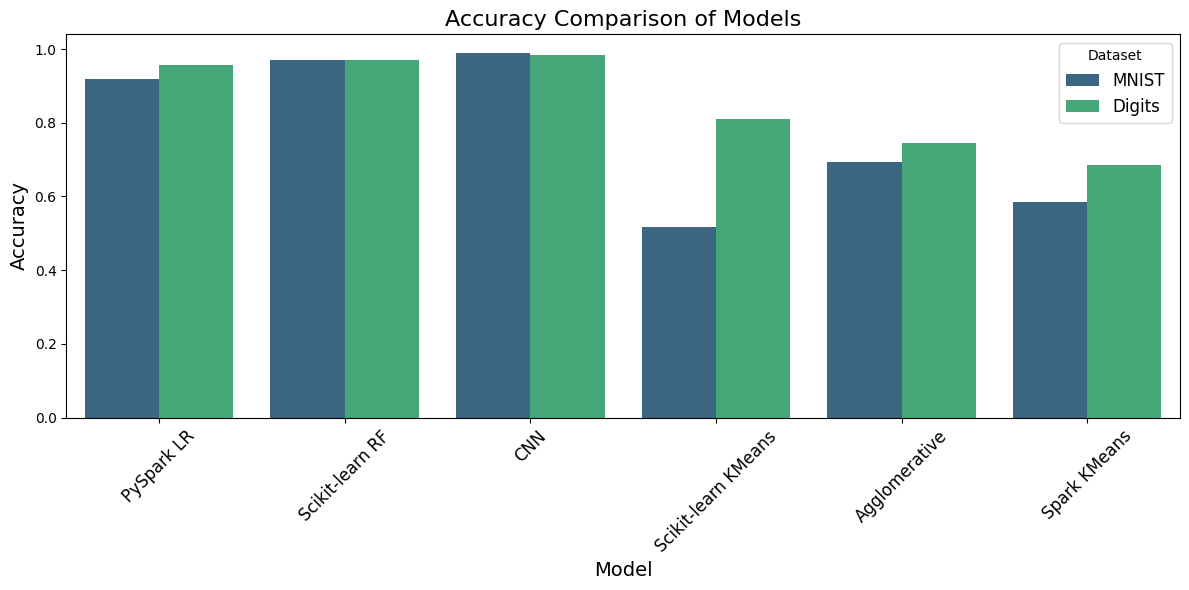

In [ ]:
# Set up the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=df, palette='viridis')

# Add labels and title
plt.title('Accuracy Comparison of Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Dataset', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

**Comparing the training time of models on both datasets**

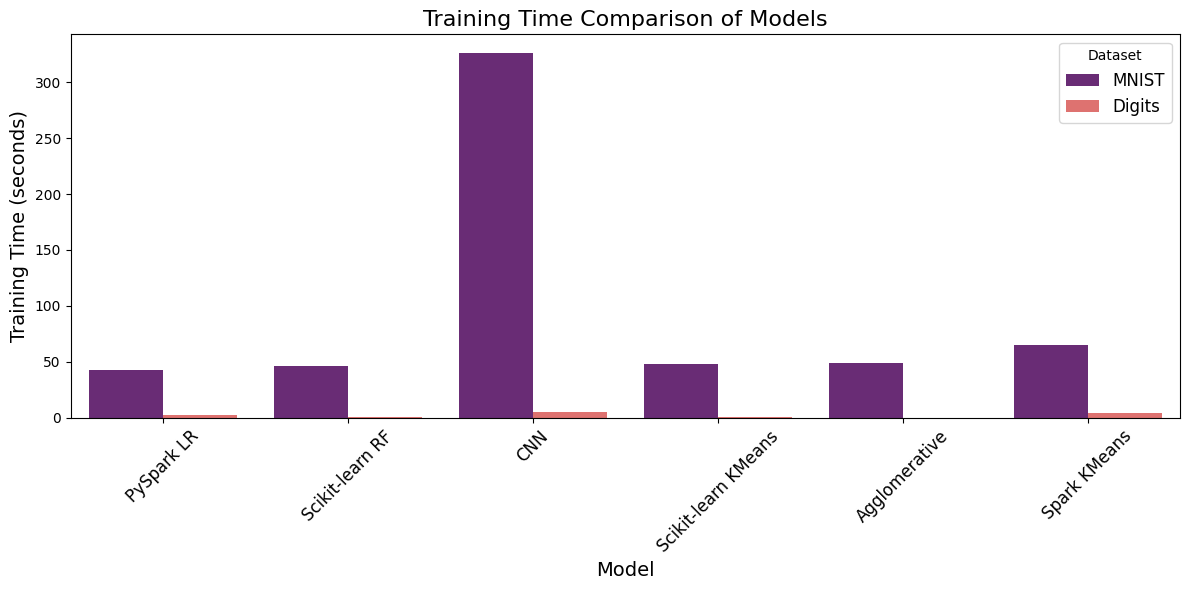

In [ ]:
# Set up the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Train Time', hue='Dataset', data=df, palette='magma')

# Add labels and title
plt.title('Training Time Comparison of Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Training Time (seconds)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Dataset', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

**Confusion matrix of the best and worst models**

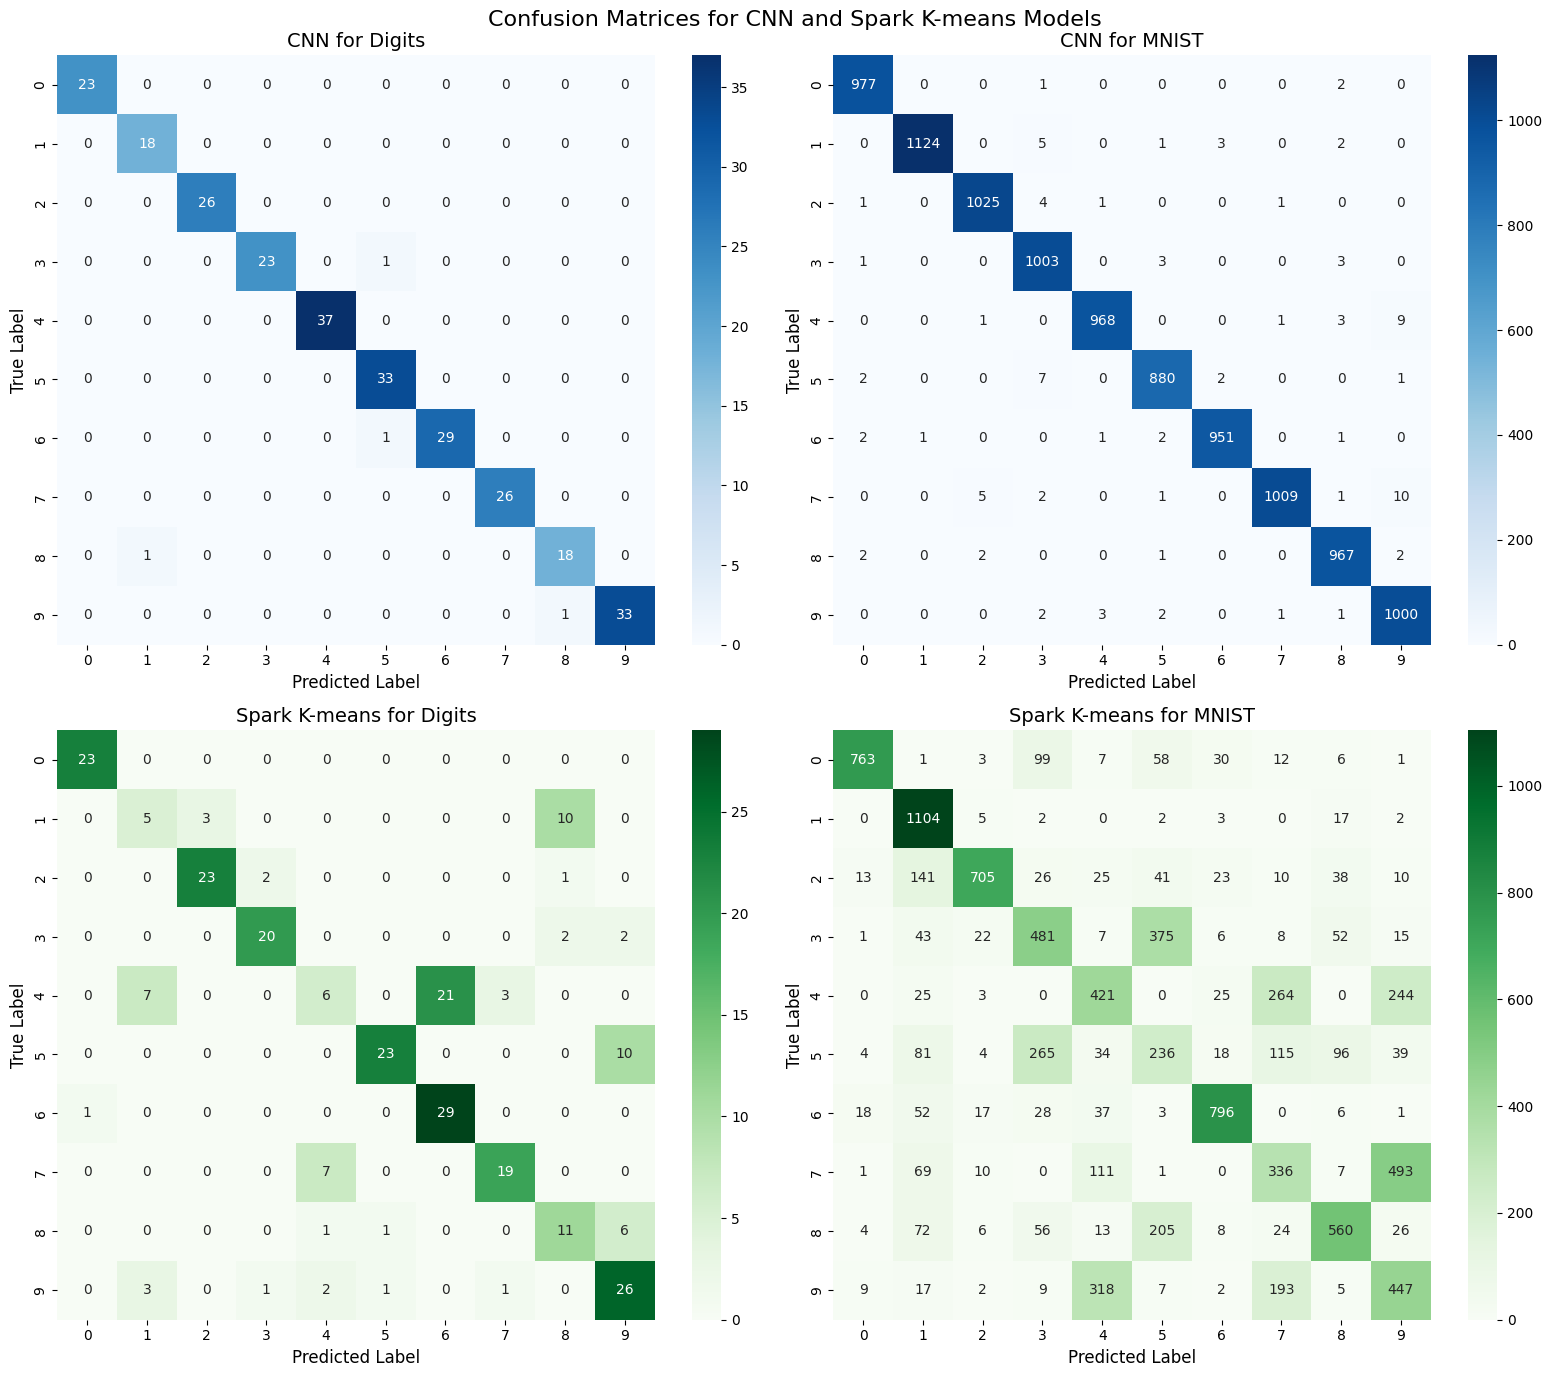

In [ ]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Confusion Matrices for CNN and Spark K-means Models', fontsize=16)

# Plot CNN for Digits
sns.heatmap(cm_digits_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('CNN for Digits', fontsize=14)
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
axes[0, 0].set_ylabel('True Label', fontsize=12)

# Plot CNN for MNIST
sns.heatmap(cm_mnist_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('CNN for MNIST', fontsize=14)
axes[0, 1].set_xlabel('Predicted Label', fontsize=12)
axes[0, 1].set_ylabel('True Label', fontsize=12)

# Plot Spark K-means for Digits
sns.heatmap(cm_digits_spark, annot=True, fmt='d', cmap='Greens', ax=axes[1, 0])
axes[1, 0].set_title('Spark K-means for Digits', fontsize=14)
axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
axes[1, 0].set_ylabel('True Label', fontsize=12)

# Plot Spark K-means for MNIST
sns.heatmap(cm_mnist_spark, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1])
axes[1, 1].set_title('Spark K-means for MNIST', fontsize=14)
axes[1, 1].set_xlabel('Predicted Label', fontsize=12)
axes[1, 1].set_ylabel('True Label', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

**Overall Metric Visualization**

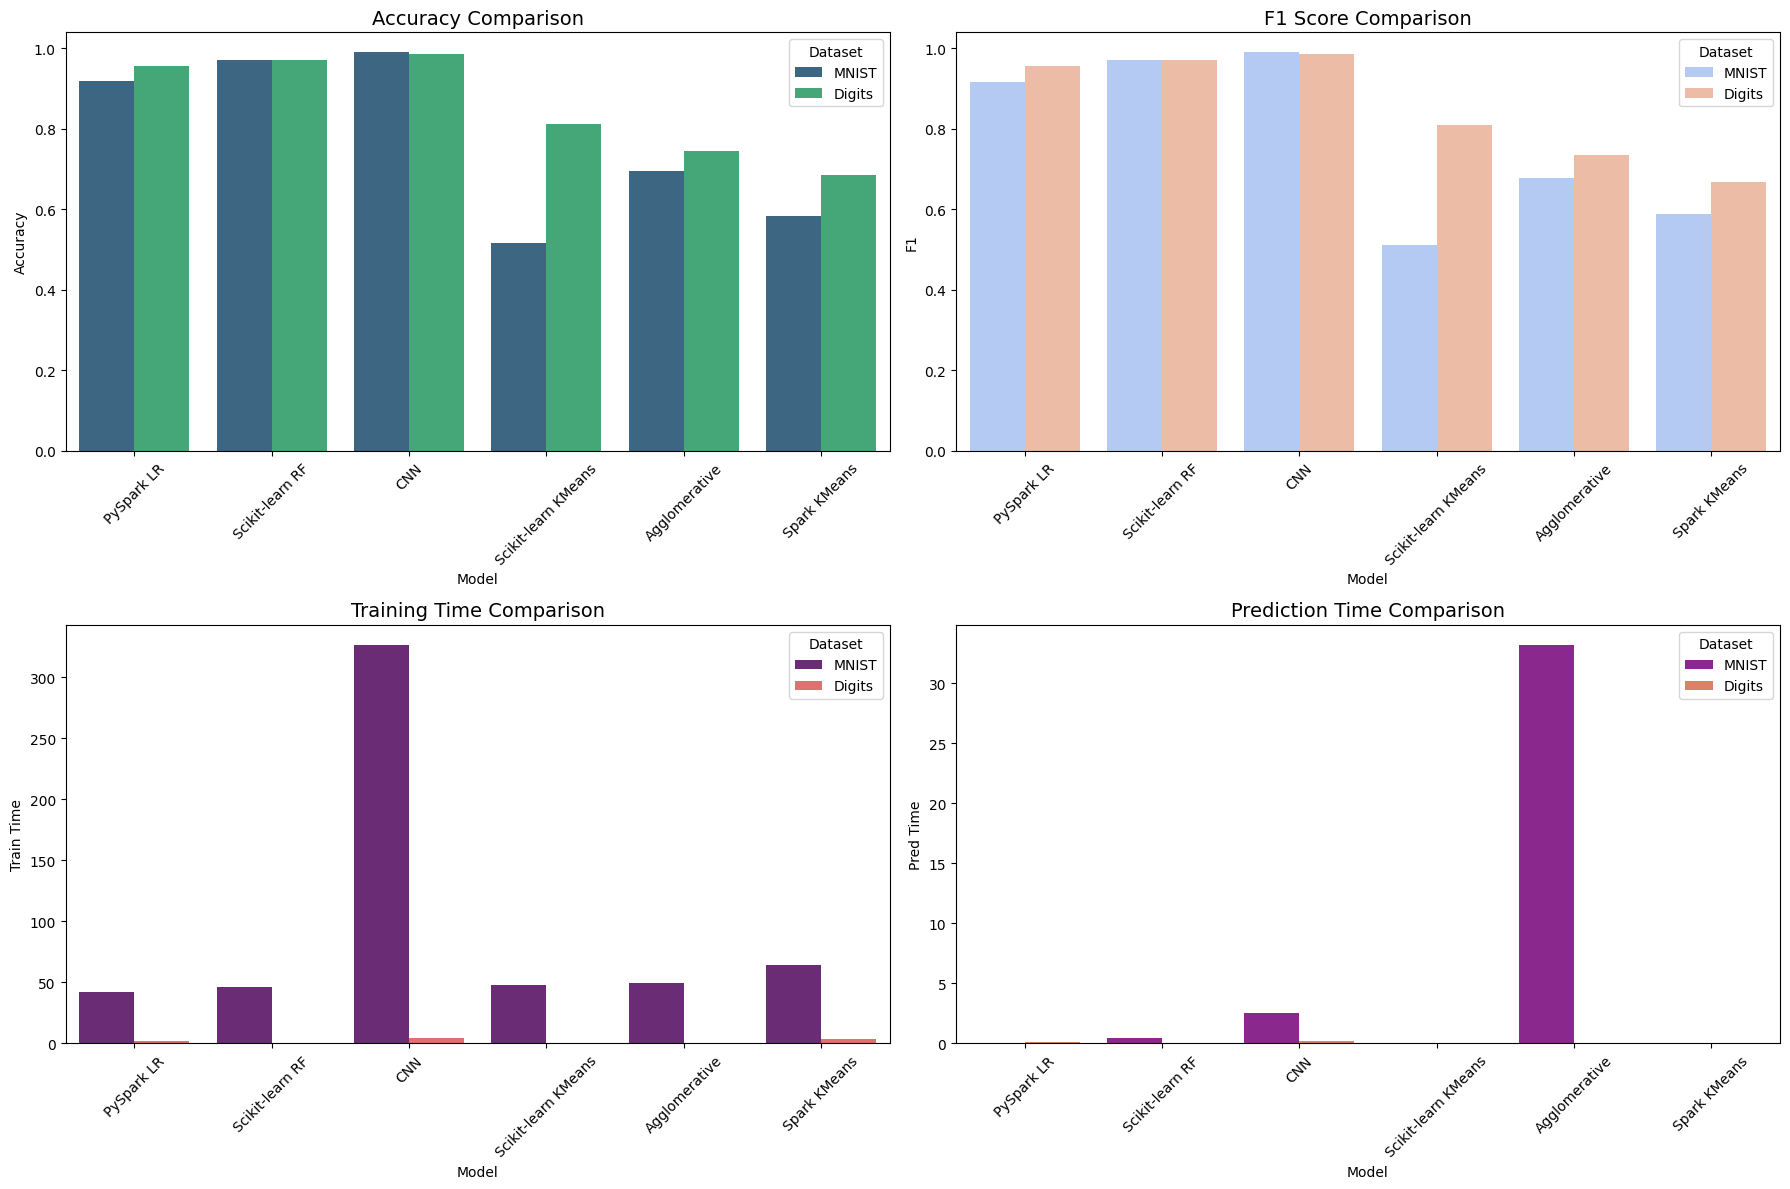

In [ ]:
# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot accuracy
sns.barplot(ax=axes[0, 0], x='Model', y='Accuracy', hue='Dataset', data=df, palette='viridis')
axes[0, 0].set_title('Accuracy Comparison', fontsize=14)
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

# Plot F1 score
sns.barplot(ax=axes[0, 1], x='Model', y='F1', hue='Dataset', data=df, palette='coolwarm')
axes[0, 1].set_title('F1 Score Comparison', fontsize=14)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# Plot training time
sns.barplot(ax=axes[1, 0], x='Model', y='Train Time', hue='Dataset', data=df, palette='magma')
axes[1, 0].set_title('Training Time Comparison', fontsize=14)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# Plot prediction time
sns.barplot(ax=axes[1, 1], x='Model', y='Pred Time', hue='Dataset', data=df, palette='plasma')
axes[1, 1].set_title('Prediction Time Comparison', fontsize=14)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# Consolidated Report: Classification & Clustering on MNIST and Digits

---

## **Week-by-Week Summary**

### **Week 1: Classification (RF vs Logistic Regression)**
- **Key Models**: Scikit-learn Random Forest (RF) vs PySpark Logistic Regression (LR).  
- **Results**:  
  - **RF**: Dominated with **97.05%** (MNIST) and **97.04%** (Digits) accuracy.  
  - **LR**: Lagged behind at **91.81%** (MNIST) and **95.56%** (Digits).  
- **Takeaway**: RF outperformed LR in accuracy and speed, highlighting its robustness for image classification.

---

### **Week 2: CNN & Pretrained Models**
- **Key Models**: Custom CNN vs Pretrained CNN.  
- **Results**:  
  - **Custom CNN**: Achieved **99.04%** (MNIST) and **98.52%** (Digits) accuracy.  
  - **Pretrained CNN**: Slightly better at **99.59%** (MNIST) with no training time.  
- **Takeaway**: Pretrained models use optimized architectures and prior training, reducing overfitting and improving generalization.

---

### **Week 3: Clustering (K-Means vs Agglomerative)**
- **Key Models**: Scikit-learn K-Means, Agglomerative, and PySpark K-Means.  
- **Results**:  
  - **K-Means**: Struggled on MNIST (**51.72%**) but better on Digits (**81.11%**).  
  - **Agglomerative**: Moderate performance (**69.48%** MNIST, **74.44%** Digits).  
- **Takeaway**: Clustering methods lagged significantly, underscoring their unsuitability for supervised tasks.

---

## **Overall Results & Insights**

### **Model Performance**
- **Top Performers**:  
  - **CNN**: Achieved near-perfect accuracy (**99.04% MNIST**, **98.52% Digits**) by capturing spatial hierarchies in images.  
  - **Random Forest**: A strong alternative (**97%+ accuracy**) with faster training, ideal for resource-constrained setups.  
  - **Pretrained CNN**: Edged out custom CNN (**99.59% MNIST**) due to architectural optimizations and prior knowledge from larger datasets.  

- **Clustering vs Classification**:  
  - **Clustering** (K-Means, Agglomerative) performed poorly on MNIST (**<70% accuracy**) due to:  
    - Lack of supervision to align clusters with true labels.  
    - Assumptions like spherical clusters conflicting with image data structure.  
  - **Classification** thrived by leveraging labeled data to learn discriminative features.  

### **How Pretrained CNN Outperformed Our CNN**
1. **Architectural Depth**: Pretrained models use advanced layers (e.g., dropout, batch normalization) to prevent overfitting.  
2. **Transfer Learning**: Features learned from diverse datasets (e.g., ImageNet) generalize better, even on simpler datasets like MNIST.  

### **Practical Trade-offs**
- **Speed vs Accuracy**:  
  - RF trained in **~45s** vs CNN’s **~327s** (MNIST), making RF preferable for quick iterations.  
  - CNN’s **~2s prediction time** vs RF’s **~0.5s** highlights scalability challenges for real-time applications.    